# Predicting Heart Disease Based On Physical Characteristics of Patients

# Introduction

Heart disease is an often-lethal condition, and being able to accurately predict if patients have it, based on easy-to-observe qualities, would allow for quicker action from doctors and better patient outcomes. So here we ask the question: is it possible to predict whether a patient has heart disease based on a set of measurable factors? To build a model that could answer this, we used the publicly-available heart disease dataset donated by the Hungarian Institute of Cardiology, the University Hospitals of Zurich and Basel, the V. A. Medical Center of Long Beach, and the Cleveland Clinic Foundation. Each row in this dataset represents a patient, and the columns store physical, health-related information about each patient — such as their age, sex, type of chest pain, and resting blood pressure. There are 14 variables in total. The column we are attempting to predict has values of either “true” or “false”, indicating whether a patient has some variety of heart disease. The dataset contains four databases, each with around 100 to 300 patients, donated by institutions in Switzerland, Hungary, and two locations in America. We trained and tested our model on data from all of the databases, as this gives us a larger sample size, and an additional variable to work with (region). This brings the total number of columns in our dataset to 15.

# Methods and Results



We consider multiple datasets in this analysis: data on heart disease from health centers in Cleveland, Long Beach (Veteran's Affairs), Hungary, and Switzerland. We use the KNN (K-nearest neighbours) classification algorithm to build our predictive model, and we employ forward selection (Campbell et al., 2022, section 6.8.2) to identify the best combination of predictors out of an initial set of theoretically-plausible ones. For each of the regional datasets we use, we first loaded and then "tidy" them —— this means we select a few relevant variables out of the whole, remov observations with NA values (cases where key data wasn't recorded, as these points do not work well with numbers-based classification algorithms like KNN), and also chang the datatypes of some variables that were loaded in as character vectors to numeric. The variables we are using in our predictive model are: 

1. Age (column name: age)<br>
    Regarded as the most important risk factor in developing heart disease, risk approximately triples every decade for individuals (!source). 82 percent of people who die of coronary heart disease are 65 and older (!source). As correlation between age and heart disease is already well-documented, it is likely that this will be a useful variable for the model.

1. Sex (column name: sex) <br>
    It has been established that men are at a greater risk of heart disease than pre-menopausal women (!source). There is an ongoing debate over whether men and post-menopausal women are at roughly equal risk; data from the WHO and UN disputes this idea (!source). Finally, there is evidence that women with diabetes are more likely to develop heart disease than men with the same condition. All this being considered, it is clear that sex has an impact on an individual's chances of developing heart disease, and so we use it as a variable for our model.
    
1. chest pain (column name: cp) <br>
    ...
    
1. resting blood pressure (column name: restbps) <br>
    It is well-documented that high blood pressure, over long periods of time, can damage arteries that feed the heart (!source). It has been demonstrated to increase risk of heart disease (!source). As such, we use it as a predictor in our model.
    
1. Serum Cholesterol: abnormally high levels of low-desnity lipoprotein cholesterol can narrow arteries and contribute to heart issues (!source). While primarily related to heart attacks, it is possible that this parameter could influence heart disease rates as well (it has proven medical significance) and so we include it in our model.

1. resting ECG (column name: restecg) <br>
    Resting electrocardiography is a test performed at many hospitals intended to detect various issues, including arrhthmias and evidence of coronary heart disease (!source https://www.ncbi.nlm.nih.gov/books/NBK367910/#:~:text=Introduction,hypertrophy%20and%20bundle%20branch%20blocks.). As it is an established test that can be used to detect hints of certain varieties of heart disease, we include it as a variable for our model.
    
1. Max Heart Rate Achieved/Thalach (column name: thalach) <br>
    Increases in heart rate has been associated with risk of cardiac death; 10 more beats per minute can yield a 20% higher risk of cardiac death (!source). As this variable is clearly correlated with heart disease, we included it in our model.
    
1. exercise induced angina (column name: exang) <br>
    Exercise-induced angia is chest pain that a patient experiences while exercising, and has been linked to heart disease in the past (!source). With an established connection to heart disease, we include it in our model.
    
1. peak exercise (column name: oldpeak) <br>
    Sometimes patients who are being tested for heart disease are made to run on a treadmill while wearing an ECG; depending on the results of this test, a patient may be referred to further urgent testing. As this is a useful, common test employed by experts trying to determine whether a patient has heart disease, we include it in our model as a variable.

We attempt to keep the number of predictors considered low as too many predictors can interfere with the accuracy of forward selection (Campbell et al., 2022, section 6.8.2, para. 8).

In this analysis we build and test models on each region separately, and on a combined dataset produced by combining the data for all regions. We use the K-nearest neighbours classification algorithm with forward selection and cross validation to build our predictive models. Forward selection helps ensure an optimal choice of parameters for accuracy, and cross validation identifies the best model parameter of "k" for each model being constructed. Model accuracy is eventually evaluated against a testing dataset, the accuracy of the model for each region's model is calculated, and the results of the model are displayed in a confusion matrix.

A scatterplot is used to visualize the predictions of an approximate version of the model, but this plot is neccessarily not a perfect representation due to the use of more than three variables by the final model, which precludes intuitive visualization.

This code should take roughly 1000 seconds to run.

## Preliminary Exploratory Data Analysis

### Imports
In this cell we import a number of neccessary libraries, whose functions we will be using frequently in the analysis. Of note are tidyverse and tidymodels. We also set the seed of the program so that running it multiple times will produce consistent results

In [38]:
# load libraries
library(tidyverse)
library(repr)
library(tidymodels)

options(repr.matrix.max.rows = 6) # change how tables are displayed
set.seed(1048596) # arbitrary seed number picked as an obscure reference to Steins;Gate.

### Reading and tidying the data: to start with, a function

A key concept in programming is DRY — Don't Repeat Yourself — and so we start by writing a function which performs some of the more repetitive tasks on a freshly-loaded dataframe for us. This includes selecting the columns above, creating a "region" column (this will not be used as a predictor, but *will* help with separating and visualizing the data). The function we make 

- descriptively renames the initially-nameless columns retrieved from our data source, 
- assigns a region to loaded observations, 
- changes "num" (the result column) from a numeric to a character vector, 
- and selects the specific columns we want for the purposes of this analysis (age, region, cp, sex, thalach, trestbps, chol, fbs, restecg, exang, oldpeak. Details about these parameters can be found in the section above this one. 

# !!!EA Also note to self: change num to has_heart_disease or something, num makes absolutely 0 sense after it was converted to a factor.

In [2]:
# Function to tidy up each of the separate datasets
# Discovery: in the non-cleveland sets, many of the more obscure columns have missing values in some rows. If you filter out all the rows that don't have missing values anywhere you sometimes end up with none from that set.
# TODO: get domain knowledge, use to find best predictors to use

tidy_heart_data <- function(df, region="") {
    colnames(df) <- column_names
    df <- mutate(df, region=region) #cleveland
    df$num<-ifelse(df$num==0,"true","false")
    if (region != "") {
        df <- mutate(df, region=as.factor(region))
        }
    return (df |> select(num,
                         age, #
                         region,
                         cp, #
                         sex,#
                         thalach, #
                         trestbps, #
                         chol, #
                         fbs, #
                         restecg, #
                         exang, #
                         oldpeak, #
                         
                        ) |> 
                          filter(cp!="?",
                                 sex!="?",
                                 thalach!="?",
                                 trestbps!="?",
                                 trestbps!="0",
                                 chol!="?",
                                 fbs!="?",
                                 restecg!="?",
                                 exang!="?",
                                 oldpeak!="?",)|>
                                 
                        
                          mutate(region=as.factor(region),
                                 sex=as.numeric(sex),
                                 cp=as.numeric(cp),
                                 thalach=as.numeric(thalach),
                                 trestbps=as.numeric(trestbps),
                                 chol=as.numeric(chol),
                                 fbs=as.numeric(fbs),
                                 restecg=as.numeric(restecg),
                                 exang=as.numeric(exang),
                                 oldpeak=as.numeric(oldpeak),
                                 # slope=as.numeric(slope),
                                 # ca=as.numeric(ca),
                                 # thal=as.numeric(thal),
                                 num = as.factor(num)))
    }

column_names <-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")

### Reading and tidying the data: Calling the function
The cells below each call the above function with the freshly-loaded dataframe, and the region name corresponding to the loaded region. 

#### Cleveland 
In the case directly below, we load and tidy the data from the Cleveland Clinic Foundation (!source) **[[add as a source here the thing we got the datasets from]].**

In [3]:
cleveland_data<- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                         col_name = FALSE)
cleveland_data <- tidy_heart_data(cleveland_data,"C")

cleveland_data               
# Table 1

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,63,C,1,1,150,145,233,1,2,0,2.3
false,67,C,4,1,108,160,286,0,2,1,1.5
false,67,C,4,1,129,120,229,0,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,57,C,4,1,115,130,131,0,0,1,1.2
false,57,C,2,0,174,130,236,0,2,0,0.0
true,38,C,3,1,173,138,175,0,0,0,0.0


#### Hungary
Next, we load and tidy the data from The University Hospital of Basel (!source) **[[add the same thing as in the note above]]**. The usefulness of the function we wrote in reducing clutter is already evident.

In [4]:
hungarian_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                          col_name = FALSE)
hungarian_data <- tidy_heart_data(hungarian_data,"H")
hungarian_data
# Table 2

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,28,H,2,1,185,130,132,0,2,0,0
true,29,H,2,1,160,120,243,0,0,0,0
true,30,H,1,0,170,170,237,0,1,0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,56,H,4,1,150,155,342,1,0,1,3
false,58,H,2,0,110,180,393,0,0,1,1
false,65,H,4,1,115,130,275,0,1,1,1


#### Switzerland
Here we perform the same procedure for Switzerland. Note the size of this table is much smaller than the rest of the ones we have loaded so far: not only is it the smallest of the datasets we have, coming in around 130 rows, but it also includes many missing values, which means this small size gets shrunk down even further after we process it. This will have ramifications for later parts of our analysis.

In [5]:

switzerland_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_name = FALSE)
switzerland_data <- tidy_heart_data(switzerland_data,"S")
switzerland_data
# Table 3

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,38,S,4,0,156,110,0,0,0,0,0
false,38,S,3,1,128,115,0,0,0,1,0
false,42,S,4,1,99,145,0,0,0,1,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,70,S,4,1,92,115,0,0,1,1,0
false,70,S,4,1,157,140,0,1,0,1,2
false,73,S,3,0,121,160,0,0,1,0,0


#### VA Long Beach
We call the function we wrote earlier to tidy the data from the V. A. Medical Center of Long Beach.

In [6]:
va_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                   col_name = FALSE)
va_data <- tidy_heart_data(va_data,"VA")
va_data
# Table 4

Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,63,VA,4,1,112,140,260,0,1,1,3.0
true,44,VA,4,1,127,130,209,0,1,0,0.0
false,60,VA,4,1,140,132,218,0,1,1,1.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,54,VA,4,0,154,127,333,1,1,0,0
false,55,VA,4,1,100,122,223,1,1,0,0
false,62,VA,2,1,93,120,254,0,2,1,0


#### Creating the combined dataset

In this cell we combine all the data from earlier into a larger, super-dataset. This is so that we can analyze the accuracy of knn on each region separately, and then each region together, to see which is more accurate; it gives us more options to explore during our analysis. This is also why we appended a "region" column to each dataset — this hardly would have made sense if we were keeping them separate the entire time.

In [7]:


all_data <-rbind(cleveland_data,hungarian_data,switzerland_data,va_data)

all_data
# Table 5

num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
true,63,C,1,1,150,145,233,1,2,0,2.3
false,67,C,4,1,108,160,286,0,2,1,1.5
false,67,C,4,1,129,120,229,0,2,1,2.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
false,54,VA,4,0,154,127,333,1,1,0,0
false,55,VA,4,1,100,122,223,1,1,0,0
false,62,VA,2,1,93,120,254,0,2,1,0


### Summary of dataset, pre-analysis

!EA just copy-paste from the methods section of the proposal.

### Visualization, pre-analysis

Here, before performing the analysis itself, we visualize some of the data that we loaded. In figure 1 we used bar graphs to visually represent how many patients in each dataset (after tidying, which makes sense considering that we'll be working with the tidied, filtered dataset) have heart disease, and how many do not. Understanding the ratio will give us a better idea of which variable will dominate the knn algorithm; knowing broadly how many patients there are in each dataset will also partially tell us what values of K might be too high (by virtue of essentially becoming averages). This visualization also has the additional benefit in that it shows us that Switzerland will not be suitable for analysis by itself: it has too few positive cases of heart disease, at one single case, so when stratified into training and testing data one of the two will lack any positive cases. This state of affairs will also cause issues with cross-validation. Therefore, we will not perform analysis on Switzerland seperately throughout this project.

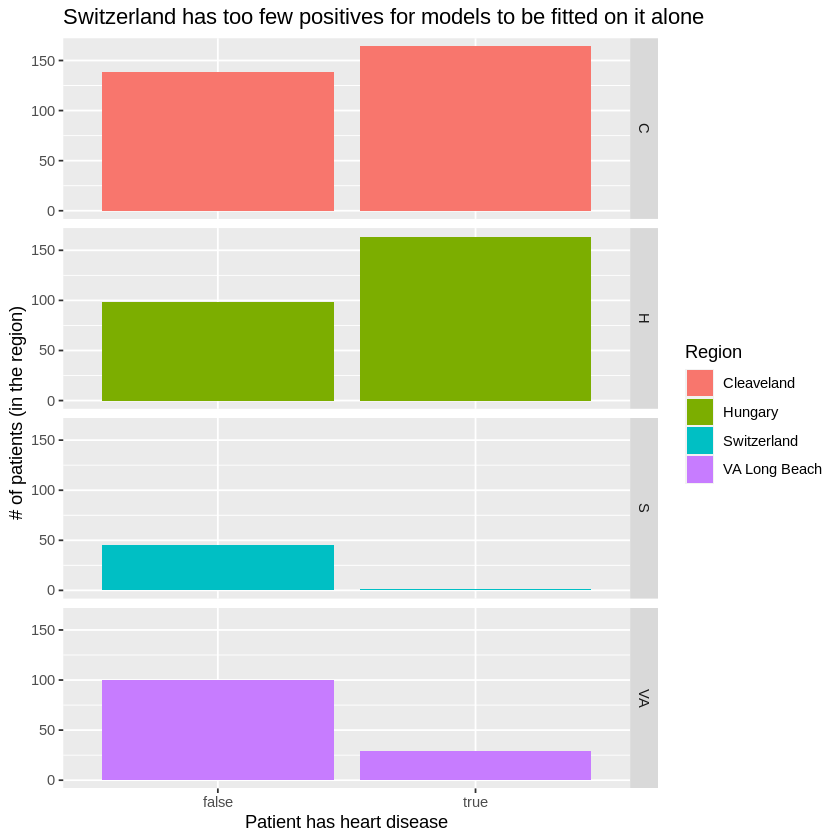

In [8]:
## TODO !EA Visualization of data relevant to the analysis (blocked on domain knowledge, need to know what variables to graph)
# Visualization of heart disease by region (will at least explain why we don't use f***ing Switzerland) 
# Of note for the description: switzerland sucks, Cleveland and Hungary (after being filtered for NA), have more people with heart disease than not.

# Figure 1
ggplot(all_data, aes(x = num, fill = region)) +
    geom_bar() +
    facet_grid(rows = vars(region)) +
    labs(x = "Patient has heart disease", y = "# of patients (in the region)", fill = "Region", title = "Switzerland has too few positives for models to be fitted on it alone") +
    scale_fill_discrete(labels = c("Cleaveland", "Hungary", "Switzerland", "VA Long Beach"))


### Splitting the data into training and testing sets

In this cell we split each of our regional datasets (and our combined dataset) into  training and testing sets; the ratio is 75% training, 25% testing, and stratification is done on the "num" column, to ensure that both sets have at least a few positive and negative cases each.

In [9]:
#split all the datasets into training and testing sets

cleveland_split <- initial_split(cleveland_data, prop = 0.75, strata = num)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

hungarian_split <- initial_split(hungarian_data, prop = 0.75, strata = num)
hungarian_train <- training(hungarian_split)
hungarian_test <- testing(hungarian_split)

switzerland_split <- initial_split(switzerland_data, prop = 0.75, strata = num)
switzerland_train <- training(switzerland_split)
switzerland_test <- testing(switzerland_split)

va_split <- initial_split(va_data, prop = 0.75, strata = num)
va_train <- training(va_split)
va_test <- testing(va_split)

all_split <- initial_split(all_data, prop = 0.75, strata = num)
all_train <- training(all_split)
all_test <- testing(all_split)

all_train # Table 6

num,age,region,cp,sex,thalach,trestbps,chol,fbs,restecg,exang,oldpeak
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
false,67,C,4,1,108,160,286,0,2,1,1.5
false,67,C,4,1,129,120,229,0,2,1,2.6
false,62,C,4,0,160,140,268,0,2,0,3.6
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
true,37,VA,3,1,165,118,240,0,2,0,1
true,68,VA,3,1,151,134,254,1,0,1,0
true,51,VA,4,0,96,114,258,1,2,0,1


### Forward Selection: finding the best predictors
In this cell, we write a function (written using a lot of code adapted from the textbook) which performs forward selection on a training set, which will be provided as an argument. This function then returns a tibble which lists the accuracy that results from using different combinations and numbers of predictors with the given dataframe. The specifics of this function are complex, but essentially it performs the following steps:

Starting with no predictors "used"...
1. try adding each of the unused predictors to the model formed by the current "used" predictors in turn; evaluate the accuracy of the resulting model
2. Whichever resulting model was the most accurate, becomes the new model, and the new predictor added to it is removed from the "unused" predictors
3. The process repeats until no predictors remain

A human can then choose the model with the best combination of accuracy* and simplicity** 
In this case, we multiply the accuracy stat of each combination of predictors to get a value back in units of % accuracy.

\*sometimes additional predictors will *reduce* the accuracy, after a point; sometimes the best model in terms of accuracy will have so many predictors its unwieldy to predict with. That being said, forward selection should not be used with too many predictors lest is accuracy reporting become unreliable, so the latter concern is less of an issue)
\*\*In the case of this project, because we are not even starting off with too many predictors, we use code to automatically pick the most accurate set of predictors and use it in later steps.

In [10]:
# Define a function to select best parameters for a given set of training data
# Doing this with a function makes performing forward selection on all four sets of training data much easier

# The following code was adapted for this project from Chapter 6 of "Data Science: A First Introduction" by Tiffany Timbers, Trevor Campbell, and Melissa Lee.

find_predictors <- function(df) {
#!EA rename stuff from cancer to heart disease
    
    # avoid mutating the function argument
    dataset <- df
    
    # select all numeric predictors
    names <- colnames(dataset |> select(-num,-region))
    
    # debug: print out dataset
    #dataset


    # create an empty tibble to store the results
    accuracies <- tibble(size = integer(), 
                         model_string = character(), 
                         accuracy = numeric())

    # create a model specification
    knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                                 neighbors = tune()) |>
         set_engine("kknn") |>
         set_mode("classification")

    # create a 5-fold cross-validation object
    heart_vfold <- vfold_cv(dataset, v = 5, strata = num)

    # store the total number of predictors
    n_total <- length(names)

    # stores selected predictors
    selected <- c()

    # for every size from 1 to the total number of predictors
    for (i in 1:n_total) {
        # for every predictor still not added yet
        accs <- list()
        models <- list()
        for (j in 1:length(names)) {
            # create a model string for this combination of predictors
            preds_new <- c(selected, names[[j]])
            model_string <- paste("num", "~", paste(preds_new, collapse="+"))

            # create a recipe from the model string
            heart_recipe <- recipe(as.formula(model_string), 
                                    data = dataset) |>
                              step_scale(all_predictors()) |>
                              step_center(all_predictors())

            # tune the KNN classifier with these predictors, 
            # and collect the accuracy for the best K
            acc <- workflow() |>
              add_recipe(heart_recipe) |>
              add_model(knn_spec) |>
              tune_grid(resamples = heart_vfold, grid = 10) |>
              collect_metrics() |>
              filter(.metric == "accuracy") |>
              summarize(mx = max(mean))
            acc <- acc$mx |> unlist()

            # add this result to the dataframe
            accs[[j]] <- acc
            models[[j]] <- model_string
        }
        jstar <- which.max(unlist(accs))
        accuracies <- accuracies |> 
          add_row(size = i, 
                  model_string = models[[jstar]], 
                  accuracy = accs[[jstar]])
        selected <- c(selected, names[[jstar]])
        names <- names[-jstar]
    }

    accuracies <- mutate(accuracies, percent_accuracy = accuracy*100)

    return(accuracies)

}
    




### Applying the function to calculate best predictor sets
In the cell below we calculate the best set of predictors for each data set (excluding Switzerland, for reasons mentioned earlier), using the function we wrote above. The highest-accuracy set of predictors for each dataset is printed out. These 

In [11]:
all_accuracy <- find_predictors(all_train)
print(all_accuracy |> select(model_string, percent_accuracy) |> slice_max(order_by = percent_accuracy, n = 1))

cleveland_accuracy <- find_predictors(cleveland_train)
print(cleveland_accuracy |> select(model_string, percent_accuracy) |> slice_max(order_by = percent_accuracy, n = 1))

hungarian_accuracy <- find_predictors(hungarian_train)
print(hungarian_accuracy |> select(model_string, percent_accuracy) |> slice_max(order_by = percent_accuracy, n = 1))

# switzerland_accuracy <- find_predictors(switzerland_train) # Note: this dataset is way too small, such that many validation sets will lack "true" values. Tune the filtering-out of NA values, or just don't test it.
# print(switzerland_accuracy, n=10)

va_accuracy <- find_predictors(va_train)
print(va_accuracy |> select(model_string, percent_accuracy) |> slice_max(order_by = percent_accuracy, n = 1))

# A tibble: 1 × 2
  model_string                                   percent_accuracy
  <chr>                                                     <dbl>
1 num ~ thalach+cp+exang+fbs+oldpeak+sex+restecg             79.4
# A tibble: 1 × 2
  model_string                                                  percent_accuracy
  <chr>                                                                    <dbl>
1 num ~ thalach+cp+exang+oldpeak+age+sex+restecg+trestbps+chol…             82.8
# A tibble: 1 × 2
  model_string                                      percent_accuracy
  <chr>                                                        <dbl>
1 num ~ cp+sex+chol+oldpeak+thalach+age+restecg+fbs             87.7
# A tibble: 1 × 2
  model_string                            percent_accuracy
  <chr>                                              <dbl>
1 num ~ sex+age+chol+fbs+exang+restecg+cp             85.5


### Plotting the accuracy of different sets of predictors for each region
In the following code cells, to confirm that we picked good choices for our predictor sets, we graph the number of predictors selected against the accuracy of each set of predictors. The function we write below helps speed this process up; given an accuracy dataframe of the type that is returned by the find_predictors() function we wrote, it will produce a graph of the # of predictors of each model vs the accuracy the model provides.

In [12]:
plot_accuracy <- function(accur, t="UNDEFINED"){
    ggplot(accur, aes(x = size, y = percent_accuracy)) +
        geom_point() +
        geom_line() +
        labs(x = "Number of predictors", y = "Accuracy (%)", title = paste("Percent accuracy vs # of predictors for",t)) +
        theme(text = element_text(size = 15))
    }

In the cell below we plot the accuracy of models trained on the super-dataset of all regions combined. The "elbow" appears to be at the point where the number of predictors is equal to !EA

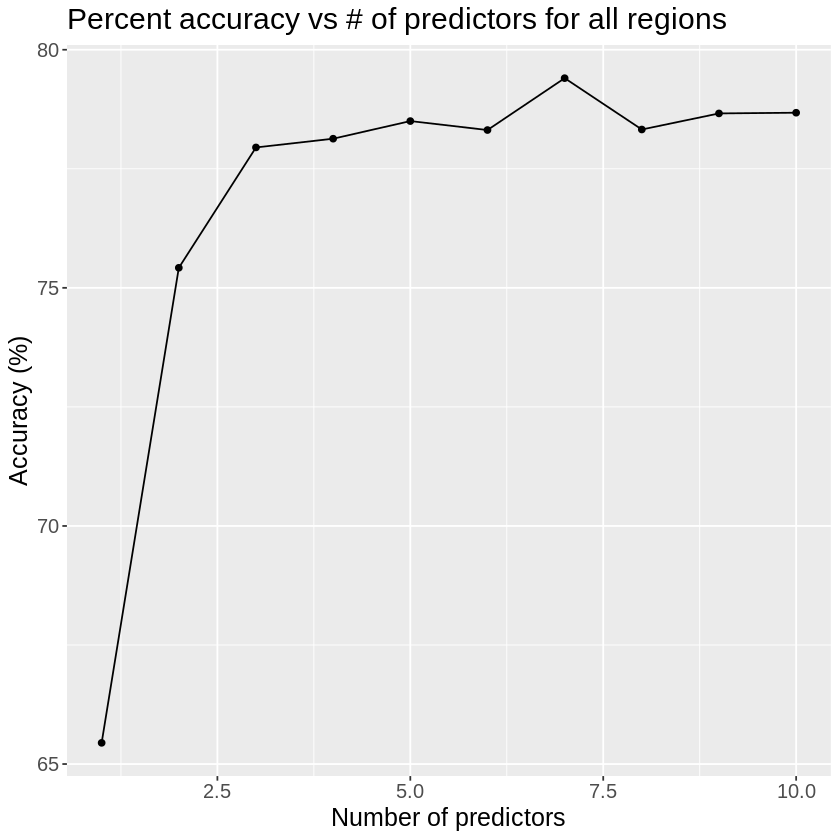

In [13]:
plot_accuracy(all_accuracy, "all regions")

In the cell below we plot the accuracy of models trained on the Cleveland Clinic Foundation dataset. The "elbow" appears to be at the point where the number of predictors is equal to !EA

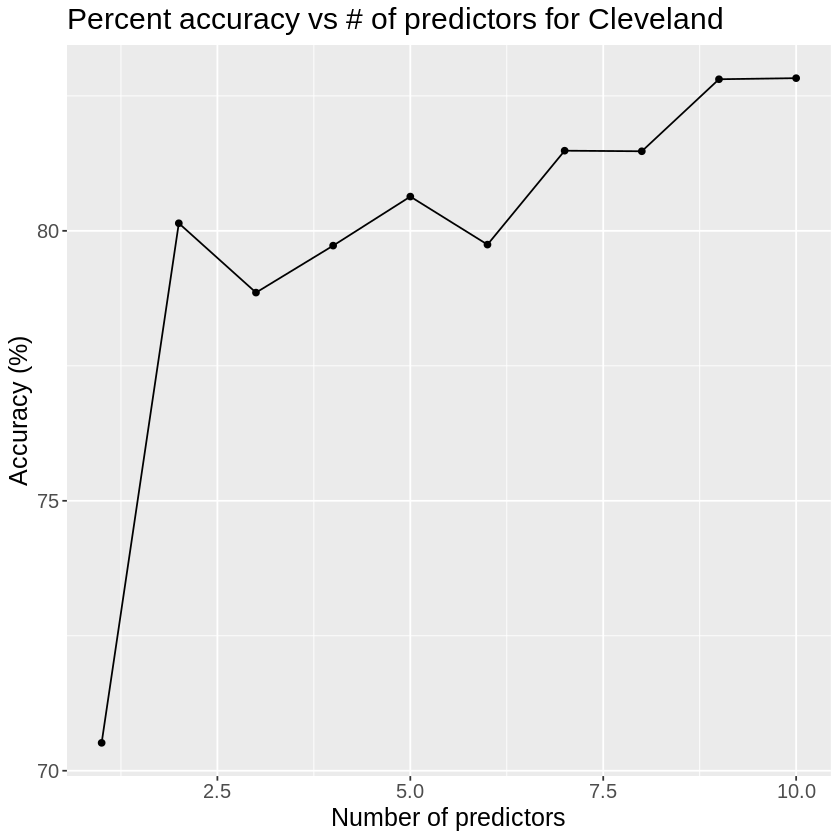

In [14]:
plot_accuracy(cleveland_accuracy, "Cleveland")

In the cell below we plot the accuracy of models trained on the University Hospital of Basel dataset. The "elbow" appears to be at the point where the number of predictors is equal to !EA

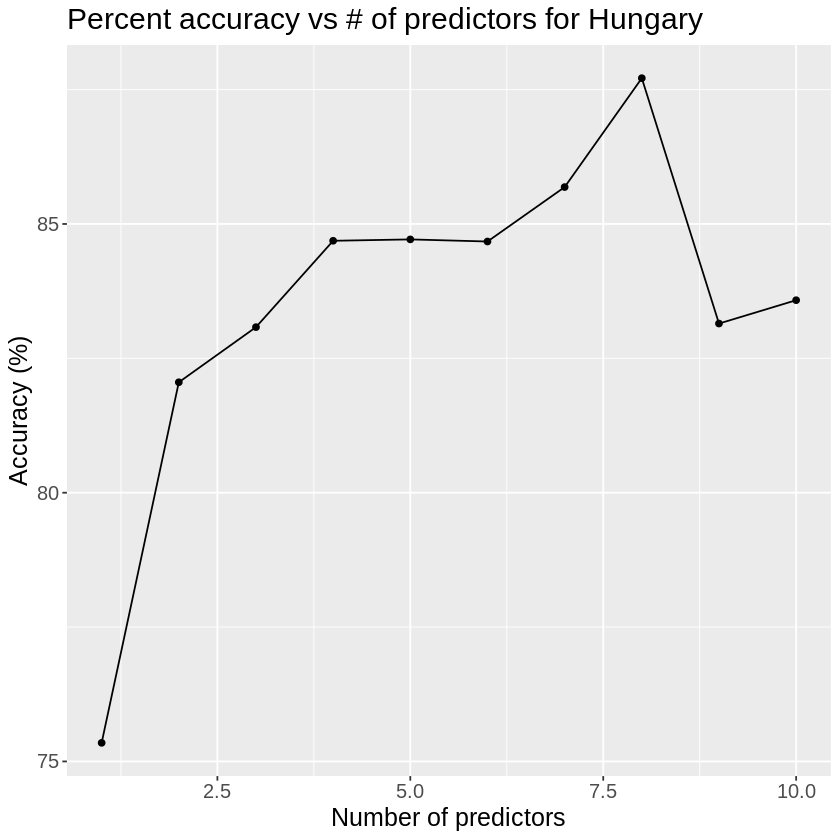

In [15]:
plot_accuracy(hungarian_accuracy, "Hungary")

In the cell below we plot the accuracy of models trained on the Veterans Affairs Long Beach Medical Center dataset. The "elbow" appears to be at the point where the number of predictors is equal to !EA

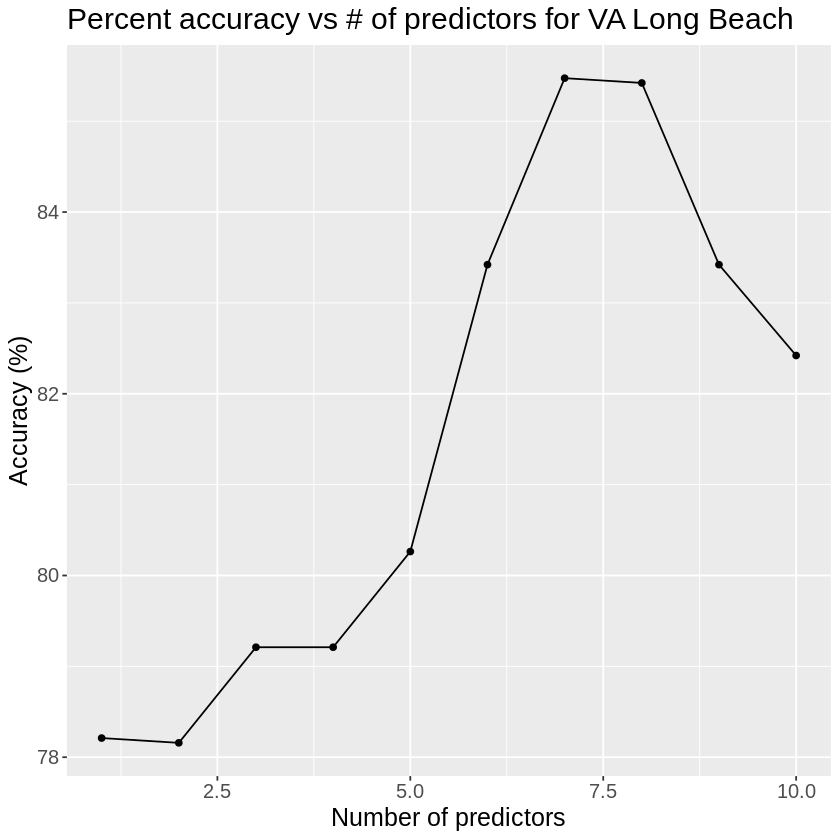

In [16]:
plot_accuracy(va_accuracy, "VA Long Beach")

Do note that while the textbook says to pick the "elbow" of the graph, we let our code automatically pick the model with the highest accuracy, out of concern that our relative inexperience will lead to us picking a poor elbow and compromising the accuracy of the model. # !EA maybe just delete this and take the punch and rewrite things so that we manually judge the elbow. Ahhhhh but that would suck the current way is cool. Think on it. Or maybe someone else can make the call. Ahh just do it. But later, I'm not ready yet to kill my over-engineered darling.

### Checking accuracy against the testing data | the final step
In the code cell below, we write a functioon that takes an accuracy dataframe (of the type outputted by the forward-selection function we built earlier), a training dataframe, and a testing dataframe, fits a knn classification model using the best value of "k", and then checks the accuracy of this fitted model against the testing set. The function returns a tuple (two-element vector) with the measured accuracy and the best value of K as elements (we will use the best value of K in a later visualization). The process here closely follows the types of problems we have done in-class, but at a high level:

1. The best set of predictors is pulled from the "accuracy" dataframe.
1. A recipe is created using this set of predictors; all predictors are scaled and centered
1. A model specification is set up, with the neighbors argument equal to "tune()" -- we have to pick the best value of K for our model before we evaluate its accuracy.
1. A fold object is created, with the # of folds equal to 10, for the sake of greater precision. At this point enough randomness has appeared that we want to be as precise as we can be.
1. The model is tuned, the accuracy for each value of K collected, and the best value of K is extracted and saved to a variable
1. Another KNN model is created, this time using the best value of K, identified in the previous steps, as its neighbors value.
1. This KNN model is fit on the training data, and then used to predict values in the testing set.
1. The prediction is tidied up a bit, with only the .estimate column of the "accuracy" observation being kept, and it being renamed to "accuracy."
1. The accuracy of the model using the best value of K, as well as this best value of K, are returned.

In [67]:
model_and_fit <- function(accuracy_df, train_df, test_df, region=""){
    # get predictors with max accuracy
    best_predictors <- accuracy_df |> slice_max(percent_accuracy, n = 1) |> pull(model_string)
    
    df_recipe <- recipe(as.formula(best_predictors), data = train_df) |> 
        step_scale(all_predictors()) |> 
        step_center(all_predictors())
    
    df_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")
    
    df_fold <- vfold_cv(train_df, v = 10, strata = num)
    
    df_k_fit <- workflow() |>
        add_recipe(df_recipe) |>
        add_model(df_spec_tune) |>
        tune_grid(resamples = df_fold, grid = 10) |>
        collect_metrics()
    
    best_k <- df_k_fit |> slice_max(mean, n = 1, with_ties = FALSE) |> select(neighbors) |> pull()
    print(paste("The best value of K for", region, "is", best_k))
    
    df_spec_k <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |> set_engine("kknn") |> set_mode("classification")
    
    df_fit <- workflow() |>
        add_recipe(df_recipe) |>
        add_model(df_spec_k) |>
        fit(data = train_df)

    df_summary <- df_fit |>
        predict(test_df) |>
        bind_cols(test_df) |>
        metrics(truth = num, estimate = .pred_class) |>
        filter(.metric == "accuracy") |>
        select(.estimate) |>
        rename(accuracy = .estimate) |>
        pull()

    df_conf_mat <- df_fit |>  predict(test_df) |>
                              bind_cols(test_df) |>
                              conf_mat(truth = num, estimate = .pred_class)
    return(c(df_summary,best_k,df_conf_mat)) # return the tuple so that I can access best_k in code later
    }

# model_and_fit(switzerland_accuracy,switzerland_train,switzerland_test, "Switzerland")[1] # Switzerland explodes for some reason, probably due to lack of data causing unexpected inputs.




#### Calculating accuracy using test dataset: All

In the cells below we call the function we wrote above to get the accuracy of the model (using the best set of predictors and the best K) as evaluated against the testing set. In each case we must take the first element of the tuple returned by the function, as the function's return value is of the form c(*accuracy*, *best_k*). The cell directly below this one calculates and extracts the accuracy of the model we created for the super-dataset, comprised of information from all the regions considered in this project.

In [68]:
all_mod <- model_and_fit(all_accuracy,all_train,all_test, "all regions combined")
print("Table ___ !EA: Accuracy of the best model") # These steps could have been added to the function, but in this position they help serve as titles too.
all_mod[1]
print("Table ___ !EA: Confusion Matrix for all regions combined")
all_mod[3]

[1] "The best value of K for all regions combined is 14"
[1] "Table ___ !EA: Accuracy of the best model"


[[1]]
[1] 0.8172043

[1] "Table ___ !EA: Confusion Matrix for all regions combined"


$table
          Truth
Prediction false true
     false    82   20
     true     14   70


#### Calculating accuracy using test dataset: Cleveland

In the cell below we calculate the accuracy of the best model we can make using the data specifically from Cleveland.

In [19]:
cl_mod <- model_and_fit(cleveland_accuracy,cleveland_train,cleveland_test, "Cleveland")
print("Table ___ !EA: Accuracy of the best model")
cl_mod[1]
print("Table ___ !EA: Confusion Matrix for Cleveland")
cl_mod[3]

[1] "The best value of K for Cleveland is 12"


$accuracy
[1] 0.7631579

#### Calculating accuracy using test dataset: Hungary

In the cell below we calculate the accuracy of the best model we can make using the data specifically from Hungary.

In [20]:
hu_mod <- model_and_fit(hungarian_accuracy,hungarian_train,hungarian_test, "Hungary")
print("Table ___ !EA: Accuracy of the best model")
hu_mod[1]
print("Table ___ !EA: Confusion Matrix for Hungary")
hu_mod[3]

[1] "The best value of K for Hungary is 14"


$accuracy
[1] 0.7424242

#### Calculating accuracy using test dataset: VA Long Beach

In the cell below we calculate the accuracy of the best model we can make using the data specifically from VA Long Beach.

In [65]:
va_mod <- model_and_fit(va_accuracy,va_train,va_test, "VA Long Beach") 
print("Table ___ !EA: Accuracy of the best model")
va_mod[1]                                                             
print("Table ___ !EA: Confusion Matrix for VA Long Beach")
va_mod[3]

[1] "The best value of K for VA Long Beach is 6"
# A tibble: 33 × 12
   num     age region    cp   sex thalach trestbps  chol   fbs restecg exang
   <fct> <dbl> <fct>  <dbl> <dbl>   <dbl>    <dbl> <dbl> <dbl>   <dbl> <dbl>
 1 false    63 VA         4     1     112      140   260     0       1     1
 2 true     66 VA         3     1      99      110   213     1       2     1
 3 true     60 VA         3     1     140      180     0     0       1     1
 4 true     56 VA         2     1     140      126   166     0       1     0
 5 false    57 VA         4     1     148      128     0     1       1     1
 6 false    58 VA         4     1     124      116     0     0       0     0
 7 false    52 VA         3     1     180      128     0     0       1     0
 8 true     60 VA         4     1     133      120     0     0       0     1
 9 false    63 VA         4     1      84      136     0     0       0     1
10 false    55 VA         3     1     125      120     0     0       1     1
# … wit

[[1]]
[1] 0.7575758

[1] "Table ___ !EA"


$table
          Truth
Prediction false true
     false    24    7
     true      1    1


## Visualization of the analysis
In this section we use visualization to provide a more concrete interpretation of the results of our analysis. Unfortunately, because we {!EA CONFIRM THAT WE END UP WITH MORE THAN TWO PREDICTORS AFTER THE DOMAIN KNOWLEDGE SHIFT} used more than two predictors for each of our models, they are not easily graphed -- humans can only visualize things in three dimensions, and only graphs in two dimensions are truly easy to understand at a glance. This being the case, we decided to visualize the dataset and indicate the areas where a person is diagnosed with heart disease by a model that uses 2 parameters: thalach and cp !EA, which consistently, throughout all of our models for all of the different regions, appeared and played a significant role in boosting accuracy. This means we need to build a custom model for this visualization specifically. After doing this, we create a graph with "zones of classification" -- areas where any new points that fall in them get classified as having a certain class -- overlaid on top of the whole dataset. In this case, we are using the Cleveland dataset, because this is the dataset which produced the most accurate model during our analysis.

Much of the code from the following sections was adapted from the textbook.

### Part 1: Find Best K for Simplified Model
In the following cell, we identify the best value of k for our simplified, two-parameter KNN model. The process is much the same as in the model_and_fit() function we wrote earlier.

In [22]:
# Part 1: Best K for 2 predictors
# (Since we're unable to visualize more than 3 dimensions, we must pick only 2 predictors: I will select cp and thalach,
# which together had pretty decent accuracy results for most of the regions)

cleveland_recipe <- recipe(num ~ cp + thalach, data = cleveland_train) |> 
    step_scale(all_predictors()) |> 
    step_center(all_predictors())
 
cl_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> set_engine("kknn") |> set_mode("classification")

cl_fold <- vfold_cv(cleveland_train, v = 10, strata = num)

cl_k_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cl_spec_tune) |>
    tune_grid(resamples = cl_fold, grid = 10) |>
    collect_metrics()

cl_best_k <- cl_k_fit |> slice_max(mean, n = 1) |> select(neighbors) |> pull()



# Interesting idea: plot the number of datapoints in a region vs the best value of K. This can be accomplished by counting the rows of each dataframe and binding these summarized tibbles.
# Make the model_and_fit function return a tuple with the accuracy value and the best value of K so that I can pull those and bind them. Or just read the values off the output.
# ggplot(

### Part 2: Fit

In the next cell, we use the calculated best value of K in a new model that is fit on the training data.

In [23]:
# Part 2: Fit
# We're viewing cleveland because it's the most accurate. (we've also then validated the choice of past ML researchers, who used the cleveland set exclusively as well)

cleveland_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = cl_best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

cleveland_fit <- workflow() |>
    add_recipe(cleveland_recipe) |>
    add_model(cleveland_spec) |>
    fit(data = cleveland_train)


### Part 3: Graph

In the following cell, we create a grid of artificial values that will be used in visualizing where a point has to fall to be classified as having heart disease or not. We predict the !EA num variable of each of these artificial values for this same purpose. This cell uses a lot of code adapted from the textbook.

In [24]:
# Part 3: Predict
# Inspired by the textbook, posted at https://canvas.ubc.ca/courses/102025/modules/items/4720443
# Note: since we can only graph two predictors, I'm picking the two that, combined, produced decent accuracy in all examples: thalach and CP
thal_grid <- seq(min(cleveland_train$thalach),
                 max(cleveland_train$thalach),
                 length.out = 100) # sets the desired length of the sequence
cp_grid <- seq(min(cleveland_train$cp),
                 max(cleveland_train$cp),
                 length.out = 100) # sets the desired length of the sequence
combined_grid <- as_tibble(expand.grid(thalach = thal_grid, cp = cp_grid)) # TODO !EA: figure out using the docs what CP is, put its name here

predicted_grid <- predict(cleveland_fit, combined_grid)

prediction_table <- bind_cols(predicted_grid,combined_grid) |> rename(num = .pred_class)


### Part 4: Graph
In the next cell, we plot each point of the entire Cleveland dataset with the cp variable on the x axis, and the thalach variable on the y axis of a scatterplot. The predicted grid of artificial values is plotted as well, with a large size and low alpha, as a method of visualizing which locations lead to which classifications. The colors of blue and red are chosen in an attempt to be accessible to the colorblind. Each point from the original dataset is also colored based on its true value. This reveals that the cp variable equalling 4 is a good predictor for a patient having heart disease; the positive cases, and the region where new points are classified as positive, are overwhelmingly concentrated around cp = 4.

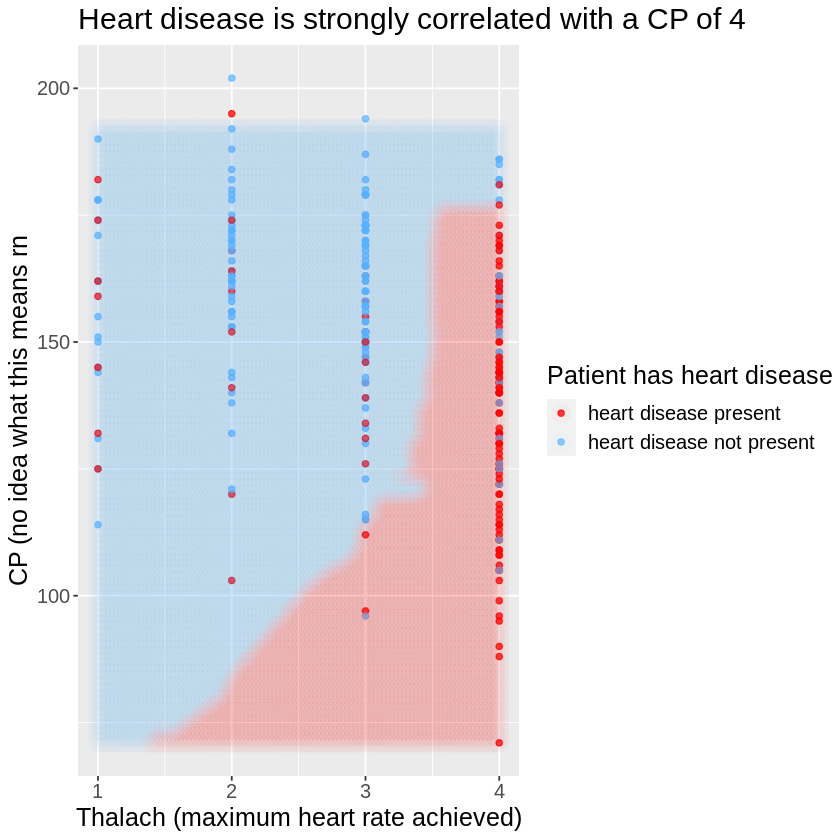

In [25]:
# Part 4: Graph
ggplot() +
    geom_point(data = cleveland_data,
               mapping = aes(x = cp, y = thalach, color = num), alpha = 0.75) +
    geom_point(data = prediction_table,
               mapping = aes(x = cp, y = thalach, color = num), alpha = 0.02, size = 5) +
    labs(color = "Patient has heart disease",
         x = "Thalach (maximum heart rate achieved)",
         y = "CP (no idea what this means rn",
         title ="Heart disease is strongly correlated with a CP of 4") +
    scale_color_manual(labels = c("heart disease present", "heart disease not present"),
                       values = c("red1", "steelblue1")) +
    theme(text = element_text(size = 15))
    
    



### Extra: See if there is a relation between number of observations and value of K

As a matter of curiosity, we plotted the count of observations versus the calculated best value of K for each of the datasets we built models for (excluding the "all" dataset). The results were mixed. There are likely too few examples to draw any solid conclusions (3 is hardly a large sample size) but the result of the smallest of the datasets (VA Long Beach) having the lowest best K is consistent with what we know: a smaller dataset, where individual points are more significant to a given prediction, is more likely to suffer from underfitting if K is large.

region,count,best_k
<fct>,<int>,<int>
C,303,12
H,261,14
VA,129,5


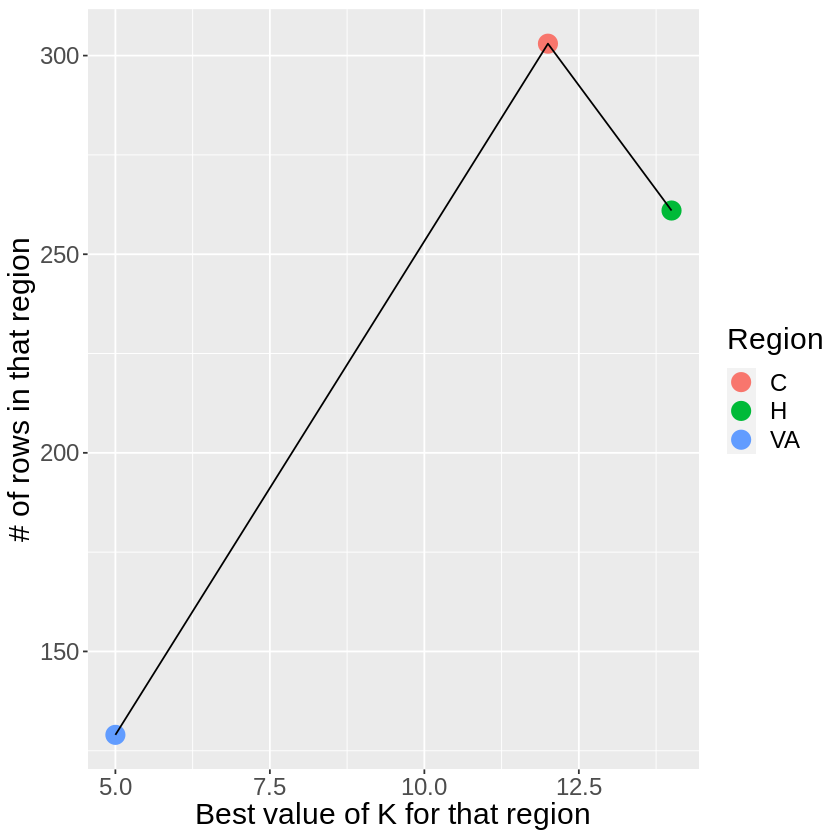

In [37]:
count_by_region <- group_by(all_data, region) |> summarize(count = n())
count_by_region <- filter(count_by_region, region != "S") # Remove Switzerland because Switzerland 's data has innaccurate knn results due to low size

# Add best k values to dataframe, convert from named list to integer vector
count_by_region <- bind_cols(count_by_region, tibble(best_k = unlist(c(cl_mod[2],hu_mod[2],va_mod[2]), use.names=FALSE)))
# count_by_region <- mutate(count_by_region, best_k = integer(best_k))
count_by_region
ggplot() +
    geom_point(data = count_by_region, 
               mapping = aes(x = best_k, y = count, color = region), size = 5) +
    geom_line(data = count_by_region, 
               mapping = aes(x = best_k, y = count)) +
    labs(x = "Best value of K for that region", y = "# of rows in that region", color = "Region") +
    theme(text = element_text(size = 18))

# With three datapoints it's hard to draw any clear conclusions. It makes sense that a dataset with very few datapoints would work best with a low value of K, though.
                             

## Methods

In order to decide what variables will be used as predictors for this model, we will employ forward selection, using the metric of accuracy. This will allow us to reliably determine, without assumptions, which variables contribute to improving the accuracy of the model and which do not. Because we have not yet done the analysis (and thus haven’t performed the forward selection yet) we cannot state which columns we will use at this time. To visualize the results, we will plot different choices of *k* for the model vs the accuracy that this choice of parameter produces. We will use this visualization to determine which choice of *k* results in the best accuracy.

## Expected Outcomes And Significance

### What do you expect to find?

With this data analysis, we would expect to find a correlation between whether or not an individual has a heart disease, and certain variables that we could use to predict it. For example, if an individual has a higher than average resting blood pressure, and higher than average cholesterol, we would expect for them to have a similarly higher chance of having a heart disease. This prediction is based on previous knowledge of heart diseases, but with our analysis we would expect to find some other factors that point to an individual having a higher or lower chance of contracting a heart disease. 

### What impact could such findings have?

These findings could allow hospitals to more accurately predict if an individual has a heart disease by attempting to classify it using our data set. It could also reduce the workload of doctors and nurses by automatically calculating how likely it is for someone to have a heart disease, which could get rid of the easy diagnoses and let doctors take over for the more difficult ones. By capturing the most impactful properties that indicate heart disease, we can also attempt to figure out methods of treatment and prevention that directly influence these properties.

### What future questions could this lead to?

This could lead to further questions about medical diagnoses from data, and if they could ever have any real life applications in the medical field. For example, based on the properties of a mole, could we predict if it is harmful or not? On the other hand, we could also ask the question of how legitimate our model is, by using a completely different heart disease data set and comparing the accuracy. Finally, as we have access to heart disease data from a variety of locations, we could ask the question: do the characteristics of heart disease remain consistent in different regions of the world? If they do not, we could try to figure out how it is different and why.